In [2]:
import numpy as np
import librosa, librosa.display
import matplotlib.pyplot as plt

In [3]:
example_file = "blues.00001.wav"

In [4]:
signal, sample_rate = librosa.load(example_file)
print(signal)
print(sample_rate)

[ 0.00341797  0.00430298  0.00137329 ... -0.11953735 -0.17495728
 -0.15118408]
22050


Text(0.5, 1.0, 'Waveform')

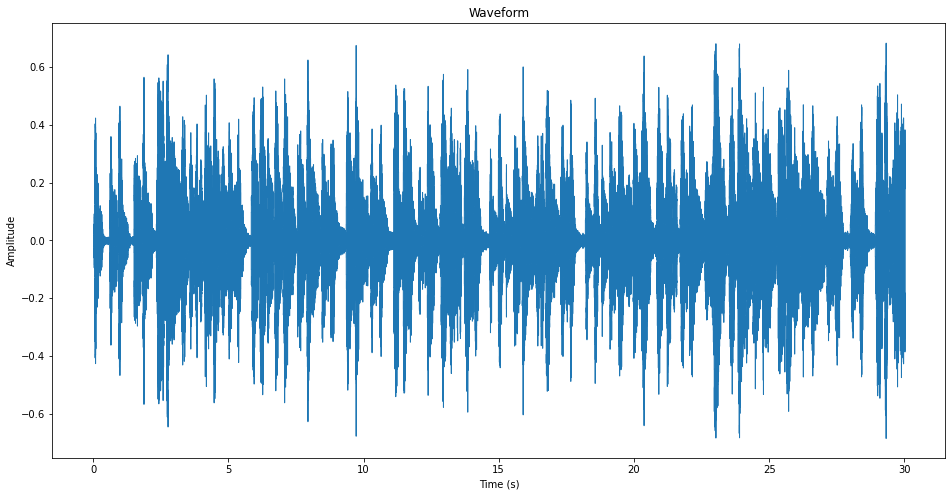

In [5]:
import librosa.display
FIG_SIZE = (16,8)
# WAVEFORM
plt.figure(figsize=FIG_SIZE)
librosa.display.waveshow(signal, sr=sample_rate)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Waveform")

Text(0.5, 1.0, 'Power Spectrum')

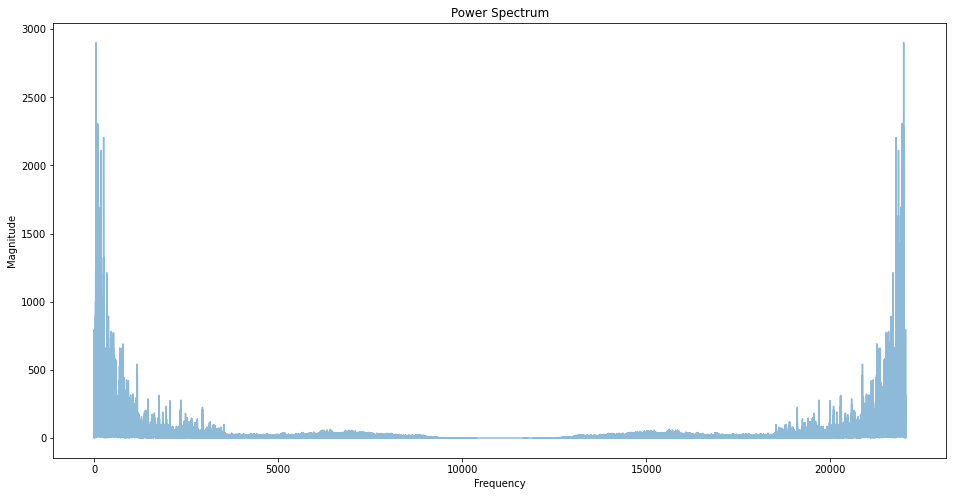

In [6]:
# Fourier Transform (FFT) - Frequency Domain
fft = np.fft.fft(signal)
# Calculate the Magnitude (abs values on complex numbers)
spectrum = np.abs(fft)
# Create the Frequency variable
f = np.linspace(0, sample_rate, len(spectrum))
# Plot Spectrum
plt.figure(figsize=FIG_SIZE)
plt.plot(f, spectrum, alpha=0.5)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.title("Power Spectrum")

Text(0.5, 1.0, 'Power Spectrum')

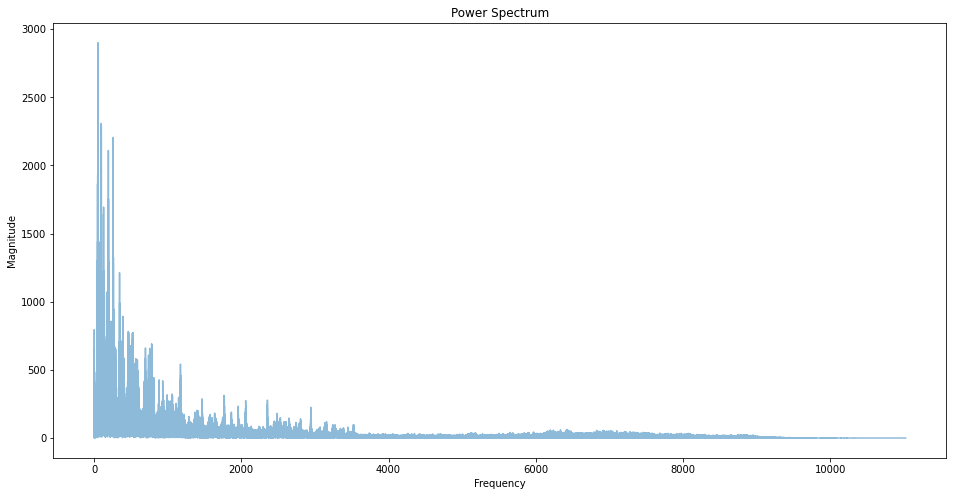

In [7]:
# Take half of the spectrum and frequency
left_spectrum = spectrum[:int(len(spectrum)/2)]
left_f = f[:int(len(spectrum)/2)]
# Plot Spectrum
plt.figure(figsize=FIG_SIZE)
plt.plot(left_f, left_spectrum, alpha=0.5)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.title("Power Spectrum")

Text(0.5, 1.0, 'Spectrogram')

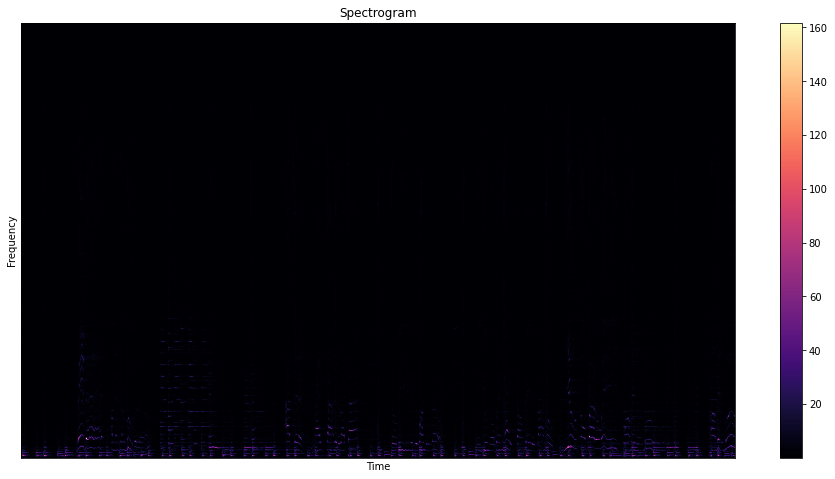

In [8]:
# Spectrogram (STFT)
hop_length = 512 # num. of samples
n_fft = 2048 # num. of samples for window
# Perform STFT
stft = librosa.stft(signal, n_fft=n_fft, hop_length=hop_length)
# Calculate the Magnitude (abs values on complex numbers)
spectrogram = np.abs(stft)
# Plot the Spectrogram
plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(spectrogram, sr=sample_rate, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.title("Spectrogram")

Text(0.5, 1.0, 'Spectrogram (dB)')

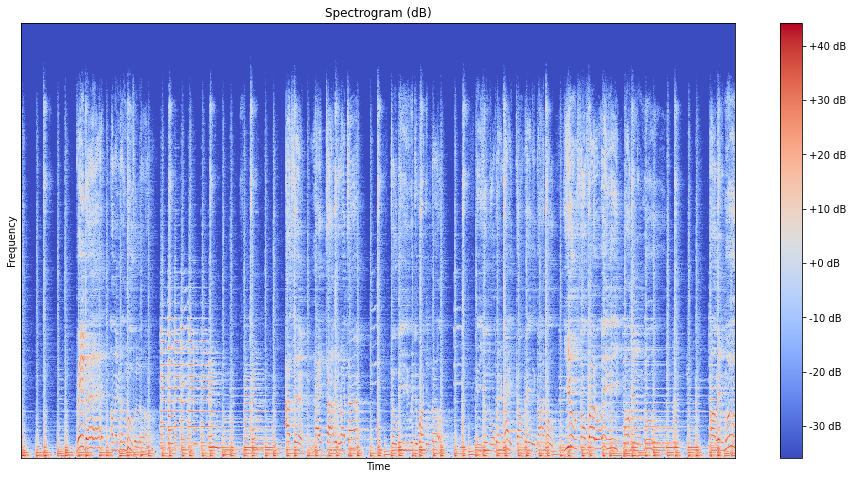

In [9]:
# Apply Logarithm to get values in Decibels
log_spectrogram = librosa.amplitude_to_db(spectrogram)
# Plot the Spectrogram in Decibels
plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(log_spectrogram, sr=sample_rate, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogram (dB)")

(1025, 1293)
(1025, 5)


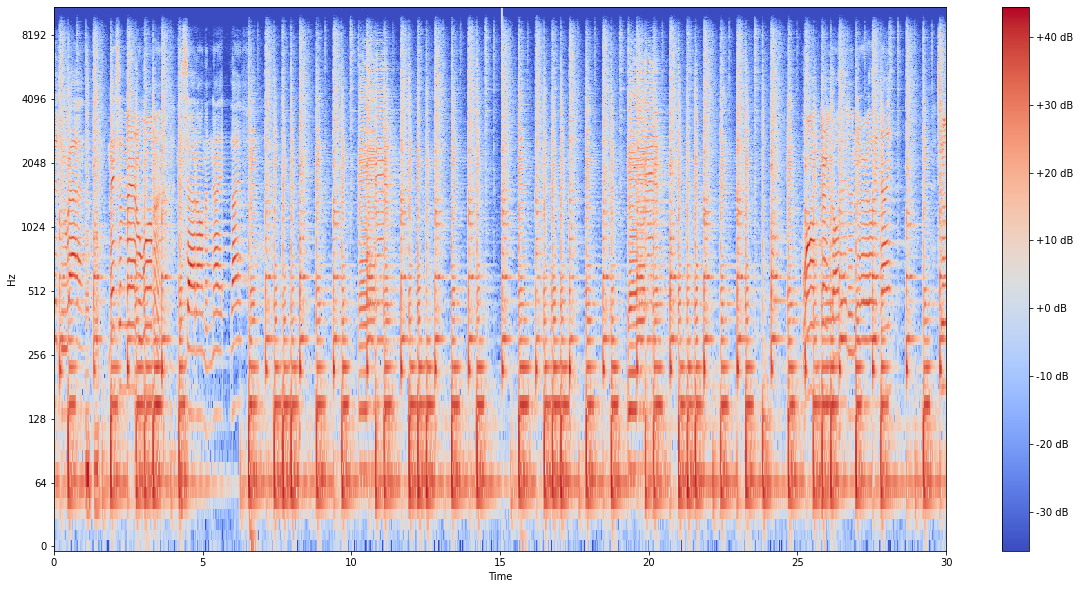

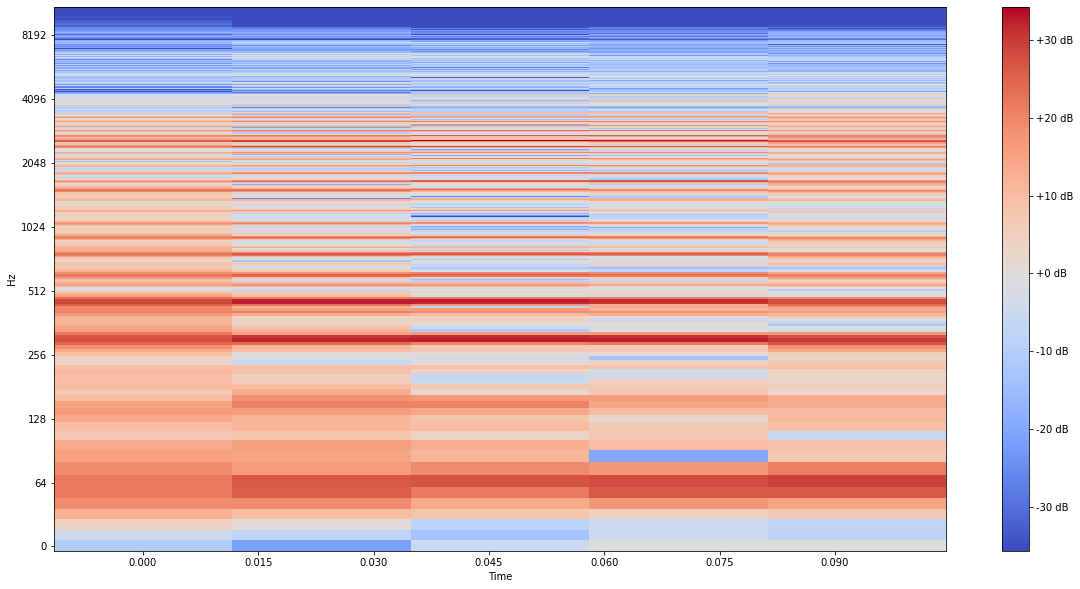

In [13]:
FRAME_SIZE = 2048
HOP_SIZE = 512
debussy_file = "rock.00002.wav"
debussy, sr = librosa.load(debussy_file)

def plot_spectrogram(Y, sr, hop_length, y_axis="linear"):
    plt.figure(figsize=(20, 10))
    librosa.display.specshow(Y, 
                             sr=sr, 
                             hop_length=hop_length, 
                             x_axis="time", 
                             y_axis=y_axis)
    plt.colorbar(format="%+2.f dB")
    

S_debussy = librosa.stft(debussy, n_fft=FRAME_SIZE, hop_length=HOP_SIZE)


Y_debussy = librosa.power_to_db(np.abs(S_debussy) ** 2)
print(np.shape(Y_debussy))

Y_debussy_block=Y_debussy[:,0:5]
print(np.shape(Y_debussy_block))
plot_spectrogram(Y_debussy, sr, HOP_SIZE, y_axis="log")
plot_spectrogram(Y_debussy_block, sr, HOP_SIZE, y_axis="log")


In [77]:
MFCCs = librosa.feature.mfcc(y=signal, sr=sample_rate, n_fft=n_fft, hop_length=hop_length, n_mfcc=13)
print(MFCCs.shape)

(13, 1293)


Text(0.5, 1.0, 'MFCCs')

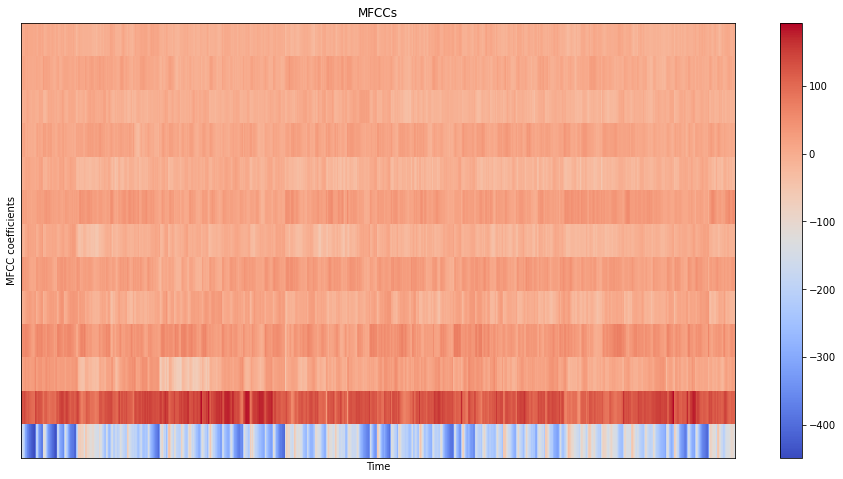

In [78]:
plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(MFCCs, sr=sample_rate, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("MFCC coefficients")

plt.colorbar(format="%+2.f dB")
plt.title("MFCCs")

In [88]:
import json
import os
import math

In [89]:
DATASET_PATH = "GTZAN_dataset/Data/genres_original"
JSON_PATH = "data_11.json"
SAMPLE_RATE = 22050
TRACK_DURATION = 30 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION

In [90]:
def save_mfcc(dataset_path, json_path, num_mfcc=13, n_fft=2048, hop_length=512, num_segments=5):
    """Extracts MFCCs from music dataset and saves them into a json file along with genre labels.
        """

    # dictionary to store mapping, labels, and MFCCs
    data = {
        "mapping": [],
        "labels": [],
        "mfcc": []
    }

    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

    # loop through all genre sub-folder
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):

        # ensure we're processing a genre sub-folder level
        if dirpath is not dataset_path:

            # save genre label (i.e., sub-folder name) in the mapping
            semantic_label = dirpath.split("/")[-1]
            data["mapping"].append(semantic_label)
            print("\nProcessing: {}".format(semantic_label))

            # process all audio files in genre sub-dir
            for f in filenames:

		# load audio file
                file_path = os.path.join(dirpath, f)
                signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)

                # process all segments of audio file
                for d in range(num_segments):

                    # calculate start and finish sample for current segment
                    start = samples_per_segment * d
                    finish = start + samples_per_segment

                    # extract mfcc
                    mfcc = librosa.feature.mfcc(y=signal[start:finish], sr=sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
                    mfcc = mfcc.T

                    # store only mfcc feature with expected number of vectors
                    if len(mfcc) == num_mfcc_vectors_per_segment:
                        data["mfcc"].append(mfcc.tolist())
                        data["labels"].append(i-1)
                        print("{}, segment:{}".format(file_path, d+1))

    # save MFCCs to json file
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)
     

In [91]:
save_mfcc(DATASET_PATH, JSON_PATH, num_segments=10)


Processing: genres_original\blues
GTZAN_dataset/Data/genres_original\blues\blues.00000.wav, segment:1
GTZAN_dataset/Data/genres_original\blues\blues.00000.wav, segment:2
GTZAN_dataset/Data/genres_original\blues\blues.00000.wav, segment:3
GTZAN_dataset/Data/genres_original\blues\blues.00000.wav, segment:4
GTZAN_dataset/Data/genres_original\blues\blues.00000.wav, segment:5
GTZAN_dataset/Data/genres_original\blues\blues.00000.wav, segment:6
GTZAN_dataset/Data/genres_original\blues\blues.00000.wav, segment:7
GTZAN_dataset/Data/genres_original\blues\blues.00000.wav, segment:8
GTZAN_dataset/Data/genres_original\blues\blues.00000.wav, segment:9
GTZAN_dataset/Data/genres_original\blues\blues.00000.wav, segment:10
GTZAN_dataset/Data/genres_original\blues\blues.00001.wav, segment:1
GTZAN_dataset/Data/genres_original\blues\blues.00001.wav, segment:2
GTZAN_dataset/Data/genres_original\blues\blues.00001.wav, segment:3
GTZAN_dataset/Data/genres_original\blues\blues.00001.wav, segment:4
GTZAN_datase